In [151]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i551965/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/i551965/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/i551965/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Spam E-Mail Detector
This notebooks contains a model which is able to predict whether a given embedding of an email is a Phishing Mail or is safe. To achieve this, it loads previously created embeddings of emails that are classified either as Phishing or Safe. It then splits up the data into a train, validate and test split before defining and training a model with the data. Finally the models performance is evaluated. The basic structure is oriented towards CRISP DM.
## CRISP-DM Phases

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment


### 1. Business Understanding

##### Objective
To develop a model that accurately predicts whether an email is a phishing email or not in order to enhance email security and protect users from potential threats.

##### Goals
- Reduce the number of phishing emails that reach users' inboxes.
- Minimize false positives to ensure legitimate emails are not incorrectly marked as phishing.
- Improve overall email security and user trust.

##### Business Questions
- What are the common characteristics of phishing emails?
- How frequently do phishing emails occur in the current email system?
- What impact do phishing emails have on user security and business operations?

##### Success Criteria
- Achieve a high accuracy rate in detecting phishing emails (e.g., over 95%).
- Maintain a low false positive rate (e.g., below 1%).
- Demonstrate improvement in email security metrics post-implementation.

##### Constraints
- Ensure the model can process and classify emails in real-time.
- Maintain user privacy and data protection while analyzing email content.
- Integrate seamlessly with existing email infrastructure and systems.

##### Key Stakeholders
- Email security team
- IT and cybersecurity departments
- End-users (employees, customers)
- Business executives

##### Requirements
- Access to historical email data, including labeled examples of phishing and non-phishing emails.
- Collaboration with the cybersecurity team to identify key features indicative of phishing.
- Tools and infrastructure for developing, testing, and deploying the model.


### 2. Data Understanding
The data comes from the following dataset: https://www.kaggle.com/datasets/subhajournal/phishingemails/data. It contains a total of 18,600 emails with 61% being labeled safe and 39% being labeled Phishing. This means that the dataset has a moderate imbalance which might lead to a model bias towards predicting emails as safe since they are overrepresented in the dataset. This is why in the Data preparation step, some approaches are tried to resolve this imbalance. 3% of the emails in the dataset consist of empty strings. The file has 3 columns:
    1. The number of the data entry
    2. The Email Text
    3. The Email Type

In [152]:
data = pd.read_csv("data/Phishing_Email.csv", skiprows=0)
data_size = len(data)

print(f"The amount of data entries is: {data_size}\n")
print(data.head())

The amount of data entries is: 18650

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  


### 3. Data Preparation
Since about 3% of the dataset contain an empty email text, it makes sense to delete those lines.

#### Removing empty entries

In [153]:
# Remove rows with missing text
data = data.dropna(subset=["Email Text"])

#### Resolving data imbalance by deleting excess emails from the safe labels

In [154]:
excess_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0] - data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Excess Safe Mails before resolving data imbalance: {excess_safe_mails}")

# Filter the DataFrame to get rows with the specified value
filtered_df = data[data['Email Type'] == 'Safe Email']

# Randomly select 100 entries to remove
rows_to_remove = filtered_df.sample(n=excess_safe_mails, random_state=1).index

# Drop the selected entries from the original DataFrame
data = data.drop(rows_to_remove)

excess_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0] - data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Excess Safe Mails after resolving data imbalance: {excess_safe_mails}")
n_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0]
n_phishing_mail = data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Number of Safe Mails: {n_safe_mails}, Number of Phishing Mails: {n_phishing_mail}")

Excess Safe Mails before resolving data imbalance: 4010
Excess Safe Mails after resolving data imbalance: 0
Number of Safe Mails: 7312, Number of Phishing Mails: 7312


#### Data cleanup
The following data preparation steps include:
- Convert all letters to lowercase
- Removing Punctuation
- Removing stopwords
- Stemming
- Lemmatization

In [155]:
def clean_texts(texts):
    # Convert to lowercase
    texts = [text.lower() for text in texts]

    # Remove punctuation
    texts = [text.translate(str.maketrans("", "", string.punctuation)) for text in texts]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    texts = [' '.join(word for word in text.split() if word not in stop_words) for text in texts]

    # Tokenize
    texts = [word_tokenize(text) for text in texts]

    # Stemming
    stemmer = PorterStemmer()
    texts = [[stemmer.stem(word) for word in text] for text in texts]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    texts = [[lemmatizer.lemmatize(word) for word in text] for text in texts]

    # Join tokens back into strings
    texts = [' '.join(text) for text in texts]

    return texts

#### Load/Create the embeddings
Here, the embeddings for the Email Texts are created to make them acceptable for the model. This is done by the sentence transformer model all-MiniLM which was retreived from huggingface (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). To speed up local testing and deployment, the embeddings are saved to a file the first time they are created and then simply loaded from that file the following runs.

In [156]:
def get_embeddings(texts):
    # Load the sentence transformer model
    sentence_transformer_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    # Preprocess the data
    cleaned_texts = clean_texts(texts)

    # Encode the text data to get embeddings
    embeddings = sentence_transformer_model.encode(cleaned_texts, show_progress_bar=True)

    # Convert embeddings to a list of lists with Python floats
    embeddings_list = [list(map(float, embedding)) for embedding in embeddings]

    # Convert embeddings to a single string representation
    embeddings_str_list = [str(embedding) for embedding in embeddings_list]
    
    return embeddings_str_list

# Check if the embeddings exist and if not, create them
if not os.path.exists("data/embeddings.csv"):
    # Create a new DataFrame with a single column for embeddings
    embeddings_df = pd.DataFrame({"embedding": get_embeddings(data["Email Text"].tolist())})

    # Concatenate the label column with the embeddings
    final_df = pd.concat([data["Email Type"].reset_index(drop=True), embeddings_df], axis=1)
    
    # Save the final DataFrame to a CSV file
    final_df.to_csv("data/embeddings.csv", index=False, sep=";")

# Load the embeddings and skip the header
data_embeddings = pd.read_csv('data/embeddings.csv', sep=';', skiprows=0)

#### Create a train, validate and test dataset

In [157]:
def format_and_load_data(train_split=0.6, validate_split=0.2, test_split=0.2):
    # Calculate the number of samples for each dataset split
    train_amount = int(data_size * train_split)
    validate_amount = int(data_size * validate_split)
    test_amount = int(data_size * test_split)
    
    examples = []

    # Process each embedding
    for _, embedding in data_embeddings.iterrows():
        label = 1 if embedding.iloc[0] == 'Phishing Email' else 0
        embedding_list = [float(i) for i in embedding.iloc[1].strip('[]').split(', ')]
        examples.append((embedding_list, label))

    # Shuffle the examples
    np.random.shuffle(examples)

    # Split data into features and labels
    X, y = zip(*examples)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Split data into training, validation and testing sets
    X_train = X[:train_amount]
    X_val = X[train_amount:train_amount + validate_amount]
    X_test = X[train_amount + validate_amount:]
    y_train = y[:train_amount]
    y_val = y[train_amount:train_amount + validate_amount]
    y_test = y[train_amount + validate_amount:]

    return X_train, y_train, X_val, y_val, X_test, y_test

### 4. Modeling

#### Build a binary classifier model to predict whether an email is spam.

The model comprises three layers:
- The first layer accepts inputs with the length of the created embeddings.
- The second layer accepts inputs of length 128.
- The third layer accepts inputs of length 1.

The first two layers use the ReLU activation function, while the last layer uses sigmoid. Sigmoid is chosen because it outputs values between 0 and 1, making it suitable for binary classification tasks. It is also very commonly used for these kind of tasks.

The data is divided into training (60%), validation (20%), and test sets (20%). During training, the validation data and validation loss are used to evaluate the model after each epoch. Validation accuracy was also considered but showed weaker results than the loss metric.

To manage the training process effectively, two callback functions are employed:
- **Early Stopping**: Halts training if the model's performance, measured by the validation dataset, begins to degrade, preventing overfitting.
- **Reduce Learning Rate on Plateau**: Adjusts the learning rate (in this case, by halving it) when the model's performance starts to decline, helping to avoid getting stuck in local minima. The patience parameter for both callbacks defines the number of epochs they wait before taking action.


In [158]:
# Load the data splits
X_train, y_train, X_val, y_val, X_test, y_test = format_and_load_data()

# Reshape data to make it acceptable for the model
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

print(X_train.shape, X_train[0].shape)

# Define model architecture
no_embedding_dim = len(X_train[0])
model = models.Sequential([
    layers.Dense(no_embedding_dim, activation='relu', input_shape=(no_embedding_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss', verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Save the model for later use
model.save("models/phishing_email_classifier.h5")

model_summary = model.summary()
model_summary

(11190, 384) (384,)
Epoch 1/50


/Users/i551965/Library/CloudStorage/OneDrive-SAPSE/BachelorStudium/DHBW/6.Semester/KI/KI-PhishingMailDetector/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8327 - loss: 0.3389 - val_accuracy: 0.9290 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9417 - loss: 0.1444 - val_accuracy: 0.9383 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9638 - loss: 0.0942 - val_accuracy: 0.9475 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9770 - loss: 0.0592 - val_accuracy: 0.9370 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 5/50
334/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0472
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9771 - loss: 0.0471 - val_accuracy: 0.9434 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9860 - loss: 0.0307 - val_accuracy

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 616,325 (2.35 MB)

 Trainable params: 205,441 (802.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 410,884 (1.57 MB)

### 5. Evaluation

In [159]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Loss and accuracy

In [160]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1370
Test Accuracy: 0.9421


#### F1-Score

In [161]:
# Evaluate the model on test data
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(np.int32)

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
Precision: 0.9154
Recall: 0.9387
F1 Score: 0.9269


#### ROC AUC Score

In [162]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9883


#### Confusion Matrix

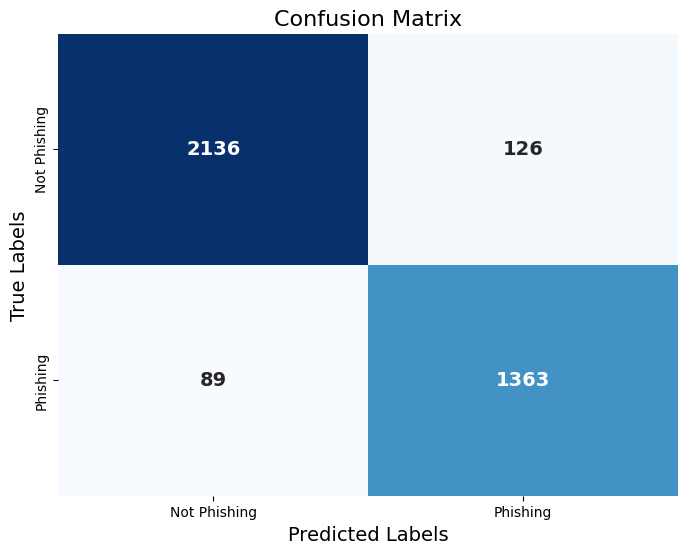

In [163]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'])
plt.show()

#### Evaluation summary

### 6. Deployment
The model can be retrieved for usage from the models folder. The code below shows how it can be used.

In [164]:
# Load the saved model for phishing email classification
model = keras.models.load_model("models/phishing_email_classifier.h5")

# Creating sample mails on my own to test and demonstrate the model
mails = ["You won the lottery! Please send us your bank account details to claim your prize.",
         "Hello I am a Nigerian prince and I want to share my fortune with you. Please send me your bank account details so I can transfer the money to you.",
         "Hello I am just confirming that I got your previous email and I will get back to you soon. Thanks.",
         "Hey, I am not feeling too good and will take tomorrow off."]

# Encode the preprocessed email text to get its embedding
email_embeddings = get_embeddings(mails)

email_embeddings_formatted = []
# Process each embedding
for ee in email_embeddings:
    embedding_list = [float(i) for i in ee.strip('[]').split(', ')]
    email_embeddings_formatted.append(embedding_list)
    
email_embeddings_formatted = np.array(email_embeddings_formatted)

# Make predictions for each embedding
predictions = model.predict(email_embeddings_formatted)

# Thresholding the predictions
threshold = 0.5
predicted_labels = ["Phishing" if prediction[0] >= threshold else "Safe" for prediction in predictions]

# Print predictions for each mail
for mail, prediction in zip(mails, predicted_labels):
    print(f"Mail: {mail}\nPrediction: {prediction}\n")

/Users/i551965/Library/CloudStorage/OneDrive-SAPSE/BachelorStudium/DHBW/6.Semester/KI/KI-PhishingMailDetector/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 51.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mail: You won the lottery! Please send us your bank account details to claim your prize.
Prediction: Phishing

Mail: Hello I am a Nigerian prince and I want to share my fortune with you. Please send me your bank account details so I can transfer the money to you.
Prediction: Phishing

Mail: Hello I am just confirming that I got your previous email and I will get back to you soon. Thanks.
Prediction: Phishing

Mail: Hey, I am not feeling too good and will take tomorrow off.
Prediction: Phishing

